This notebook contains the first step of data preprocessing for the MIT ADSP capstone project on facial emotion detection

Performed here:
- Use a facial detection model to detect if a face is present in the image
- Store images where a face was detected for subsequent preprocessing data cleaning

Google Colab setup

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set main directory
main_directory = '/content/drive/MyDrive/facial-emotion-detection-cnn'

Mounted at /content/drive


Get some helpful tools

In [ ]:
# Get face detection model to clean dataset (to remove non-faces before training)
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2024-09-20 12:52:39--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2024-09-20 12:52:39 (112 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2024-09-20 12:52:39--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubuse

In [ ]:
# Import the libraries
import os
from pathlib import Path
import imutils
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

Access 'common_functions.py' file

In [ ]:
# Specify path to common functions python file
project_path = Path(os.path.join(main_directory, 'notebooks'))
common_functions_file = 'common_functions.py'

# Construct the full path of common functions python file
full_path = project_path / common_functions_file

# Use exec to run the file
exec(open(full_path).read())

Specify location of preprocessed data after face detection. High confidence images are likely to have a face, low conficence images are not likely to have a face.

In [ ]:
# Set original data directory
original_data_directory = os.path.join(main_directory, 'data/Facial_emotion_images')

# Specify directories where the high confidence and low confidence images will be stored
high_confidence_directory = os.path.join(main_directory, 'data/face_detection/high_confidence_images')
low_confidence_directory = os.path.join(main_directory, 'data/face_detection/low_confidence_images')

# Create the directories if they do not exist
os.makedirs(high_confidence_directory, exist_ok=True)
os.makedirs(low_confidence_directory, exist_ok=True)

There are some images that are labeled but did not have faces. To clean the data, detect if the image has a face using a face detection model.




A random subset of training and validation images was selected that contained an image without a face to test the face detection model. The subset of images is listed below and stored in a list as 'image_set_for_face_detection'

In [ ]:
# Printout of image subset
printout = """
train/happy/26878.jpg
train/happy/34954.jpg
train/happy/27141.jpg
train/happy/20268.jpg
train/happy/17747.jpg
train/happy/24275.jpg
train/happy/26709.jpg
train/happy/26314.jpg
train/happy/20021.jpg
train/happy/20226.jpg
train/happy/21749.jpg
train/happy/27422.jpg
validation/happy/33228.jpg
validation/happy/3755.jpg
validation/happy/35481.jpg
validation/happy/12497.jpg
validation/happy/31908.jpg
validation/happy/23238.jpg
validation/happy/33216.jpg
validation/happy/28367.jpg
validation/happy/18226.jpg
validation/happy/20365.jpg
validation/happy/16308.jpg
validation/happy/35552.jpg
train/sad/12700.jpg
train/sad/24999.jpg
train/sad/10334.jpg
train/sad/27168.jpg
train/sad/10407.jpg
train/sad/28978.jpg
train/sad/32221.jpg
train/sad/11886.jpg
train/sad/31217.jpg
train/sad/11380.jpg
train/sad/21983.jpg
train/sad/18186.jpg
validation/sad/29243.jpg
validation/sad/33747.jpg
validation/sad/5061.jpg
validation/sad/23948.jpg
validation/sad/29970.jpg
validation/sad/28073.jpg
validation/sad/26612.jpg
validation/sad/32613.jpg
validation/sad/14048.jpg
validation/sad/1148.jpg
validation/sad/10339.jpg
validation/sad/30035.jpg
train/surprise/11257.jpg
train/surprise/12685.jpg
train/surprise/13090.jpg
train/surprise/1464.jpg
train/surprise/22583.jpg
train/surprise/6655.jpg
train/surprise/5616.jpg
train/surprise/8229.jpg
train/surprise/28986.jpg
train/surprise/11556.jpg
train/surprise/8975.jpg
train/surprise/13173.jpg
validation/surprise/4390.jpg
validation/surprise/25390.jpg
validation/surprise/11414.jpg
validation/surprise/18521.jpg
validation/surprise/21906.jpg
validation/surprise/23053.jpg
validation/surprise/24893.jpg
validation/surprise/27774.jpg
validation/surprise/13009.jpg
validation/surprise/25571.jpg
validation/surprise/16959.jpg
validation/surprise/30714.jpg
train/neutral/34311.jpg
train/neutral/26548.jpg
train/neutral/11203.jpg
train/neutral/8752.jpg
train/neutral/35819.jpg
train/neutral/32786.jpg
train/neutral/22735.jpg
train/neutral/11003.jpg
train/neutral/15144.jpg
train/neutral/16416.jpg
train/neutral/8854.jpg
train/neutral/29915.jpg
validation/neutral/25507.jpg
validation/neutral/20875.jpg
validation/neutral/33526.jpg
validation/neutral/26647.jpg
validation/neutral/16714.jpg
validation/neutral/4449.jpg
validation/neutral/23741.jpg
validation/neutral/28478.jpg
validation/neutral/33794.jpg
validation/neutral/14187.jpg
validation/neutral/8247.jpg
validation/neutral/28782.jpg
"""

# Split the printout into lines and store them in a list
image_set_for_face_detection = printout.strip().split('\n')

# Specify image paths relative to main directory
image_paths_for_face_detection = [os.path.join(original_data_directory, path) for path in image_set_for_face_detection]

Visualize how the face detection model works

In [ ]:
# Load the face detection model
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

# Function to display images in rows with specified number of images per row
def display_images_in_rows(images, images_per_row=6):
    num_images = len(images)
    images_per_row = min(num_images, images_per_row)
    num_rows = (num_images - 1) // images_per_row + 1

    for i in range(num_rows):
        start_idx = i * images_per_row
        end_idx = min(start_idx + images_per_row, num_images)
        row_images = images[start_idx:end_idx]

        row_concatenated = np.concatenate(row_images, axis=1)
        cv2_imshow(row_concatenated)

# List to store processed images
processed_images = []

# Loop through all images in the list
for image_path in image_paths_for_face_detection:
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Convert the image to color (if it's grayscale)
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Resize the image to have a maximum width of 400 pixels
    image = imutils.resize(image, width=400)
    (h, w) = image.shape[:2]

    # Prepare the input blob for the neural network
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    # Perform face detection
    net.setInput(blob)
    detections = net.forward()

    # Loop over the detections
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        # Filter out weak detections by ensuring the confidence is greater than the minimum confidence threshold
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            text = "{:.2f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

    # Store the processed image
    processed_images.append(image)

# Display the processed images in rows
display_images_in_rows(processed_images, images_per_row=6)

Output hidden; open in https://colab.research.google.com to view.

**Observations:** The face detection model seems to do a good job at identifying faces from all emotion classes even with the presence of watermarks and occlusions. It finds faces with high confidence in all cases, except for the case where there is no face in the image.

Now scan the entire original dataset to find all images where we are not confident that a face is present. High confidence images are likely to have a face, low conficence images are not likely to have a face.

WARNING: Slow time bottleneck. Store face detection results in designated directory for preprocessed data with the same directory structure as the original dataset.

In [ ]:
# Load the face detection model
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

# Directories to traverse within base directory
directories = ['train', 'validation', 'test']

# Emotion categories to traverse within directories
emotions = ['happy', 'sad', 'neutral', 'surprise']

# Loop through all directories and subdirectories
for directory in directories:
    for emotion in emotions:
        # Directory containing images
        current_directory = os.path.join(original_data_directory, directory, emotion)

        # Create the corresponding directory structure in the output directory
        output_subdirectory_low = os.path.join(low_confidence_directory, directory, emotion)
        output_subdirectory_high = os.path.join(high_confidence_directory, directory, emotion)
        os.makedirs(output_subdirectory_low, exist_ok=True)
        os.makedirs(output_subdirectory_high, exist_ok=True)

        # Loop through all images in the current directory
        for filename in os.listdir(current_directory):
            if filename.endswith((".jpg", ".png")):
                # Read the image
                image_path = os.path.join(current_directory, filename)
                image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

                # Convert the image to color (if it's grayscale)
                if len(image.shape) == 2:
                    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

                # Resize the image to have a maximum width of 400 pixels
                image = imutils.resize(image, width=400)
                (h, w) = image.shape[:2]

                # Prepare the input blob for the neural network
                blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

                # Perform face detection
                net.setInput(blob)
                detections = net.forward()

                # Flag to check if high confidence face detection is found
                high_confidence_detected = False

                # Loop over the detections
                for i in range(0, detections.shape[2]):
                    confidence = detections[0, 0, i, 2]

                    # Check if confidence is high
                    if confidence > 0.5:
                        high_confidence_detected = True

                # If high confidence detection found, save the image to high confidence directory
                if high_confidence_detected:
                    output_path = os.path.join(output_subdirectory_high, filename)
                    cv2.imwrite(output_path, image)
                # If no high confidence detection found, save the image to low confidence directory
                else:
                    output_path = os.path.join(output_subdirectory_low, filename)
                    cv2.imwrite(output_path, image)

Count and visualize the distribution of images found that did not detect a face

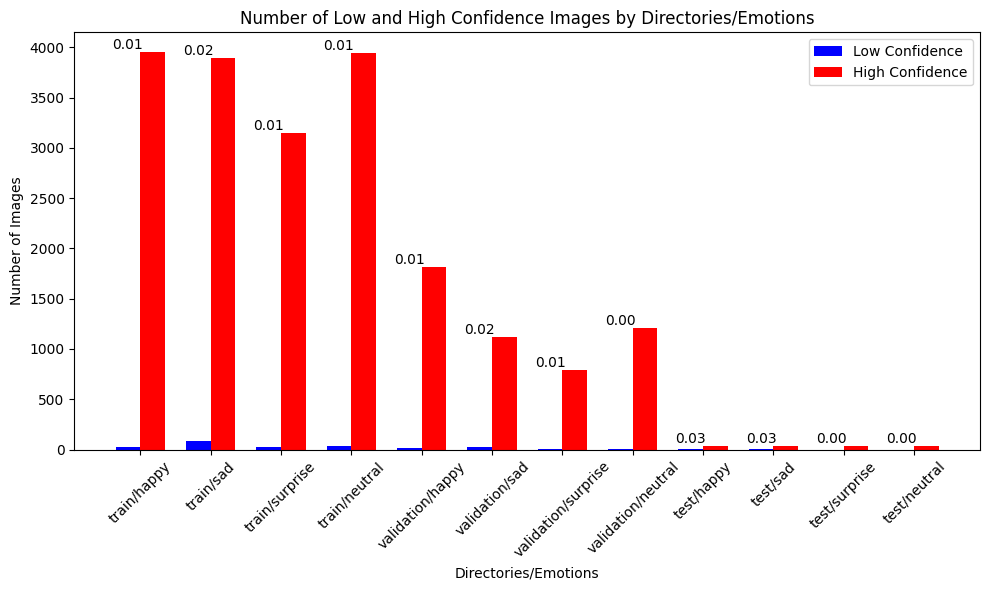

In [ ]:
# Define the list of subdirectories
subdirectories = ['train', 'validation', 'test']
emotions = ['happy', 'sad', 'surprise', 'neutral']

# Initialize lists to store counts
low_counts = []
high_counts = []

# Function to count the number of images in a directory
def count_images(directory):
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith((".jpg", ".png")):
            count += 1
    return count

# Loop through each directory and count the number of images
for subdirectory in subdirectories:
    for emotion in emotions:
        # Low Confidence Images
        directory_low = os.path.join(low_confidence_directory, subdirectory, emotion)
        count_low = count_images(directory_low)
        low_counts.append(count_low)

        # High Confidence Images
        directory_high = os.path.join(high_confidence_directory, subdirectory, emotion)
        count_high = count_images(directory_high)
        high_counts.append(count_high)

# Calculate the ratio of low to high confidence images
ratios = [low / (low + high) for low, high in zip(low_counts, high_counts)]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(subdirectories) * len(emotions))
bar_width = 0.35

# Plotting bars for low confidence images
bars_low = ax.bar(x, low_counts, bar_width, label='Low Confidence', color='b')

# Plotting bars for high confidence images
bars_high = ax.bar([i + bar_width for i in x], high_counts, bar_width, label='High Confidence', color='r')

# Adding labels and title
ax.set_xlabel('Directories/Emotions')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Low and High Confidence Images by Directories/Emotions')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels([f"{subdir}/{emotion}" for subdir in subdirectories for emotion in emotions], rotation=45)
ax.legend()

# Adding text annotations for the ratio
for i, ratio in enumerate(ratios):
    ax.text(i, max(low_counts[i], high_counts[i]), f'{ratio:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Observations:** Overall, the percentage of images where a face was not detected are small. There tend to be more 'low confidence' images in the 'sad' emotion class. Proceed with data cleaning on the 'high confidence' images where a face was detected.

Note: There are images in the test dataset where a face was not detected. Document carefully during the final model testing stage.

Show distribution of the 'high confidence' dataset (where non-face images are excluded)

In [ ]:
# Print number of files within the high-confidence image directory
print_number_of_files(high_confidence_directory)

Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/face_detection/high_confidence_images: 19984
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/face_detection/high_confidence_images/train: 14932
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/face_detection/high_confidence_images/train/happy: 3951
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/face_detection/high_confidence_images/train/sad: 3897
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/face_detection/high_confidence_images/train/neutral: 3941
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/face_detection/high_confidence_images/train/surprise: 3143
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/face_detection/high_confidence_images/validation: 4926
Number of .jpg files in /content/drive/MyDrive/facial-e

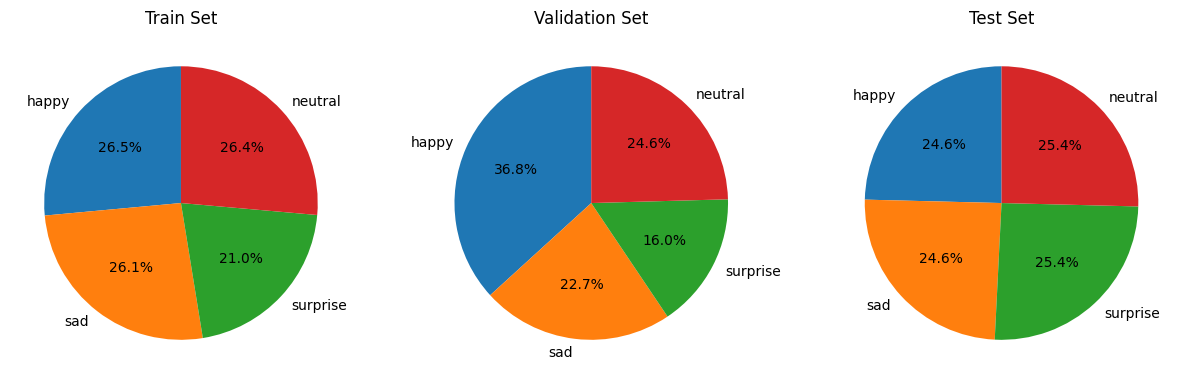



Number Total Images in Train Set: 14932 (74.72%)
Number of Total Images in Validation Set: 4926 (24.65%)
Number of Total Images in Test Set: 126 (0.63%)
Number of Total Images: 19984


In [ ]:
# Show distribution of data in train, validation, and test set
show_pie_charts(high_confidence_directory)

**Observations:** The overall distribution of the data has not changed significantly from this data cleaning step. Proceed with the 'high confidence' images to the next cleaning step.